# Hasse Search Space Estimation

## Load Data

In [1]:
import json
import numpy as np
from os import listdir
from pprint import pprint
from statistics import mean, stdev
from typing import List, Dict

In [2]:
%pip install matplotlib
import matplotlib.pyplot as plt

You should consider upgrading via the '/Users/christophstein/Documents/jku/hasse_search_spaces/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tqdm
from tqdm import tqdm

You should consider upgrading via the '/Users/christophstein/Documents/jku/hasse_search_spaces/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load data

def get_file_paths(dir_path: str = "results") -> List[str]:
    file_names = listdir(dir_path)
    file_names = [file_name for file_name in file_names if file_name.endswith(".json")]

    file_paths = [
        f"{dir_path}/{file_name}"  for file_name in file_names
    ]
    return file_paths


def load_data(file_path: str) -> Dict:
    with open(file_path, "r") as data_file:
        return json.load(data_file)

experiment_paths = get_file_paths()
experiments = [
    load_data(file_path) for file_path in experiment_paths
]

print(f"Experiment count: {len(experiments)}")
print(experiments[0])

Experiment count: 16
{'meta': {'start': '2025-11-28 16:10:40.319538', 'end': '2025-11-28 17:03:35.666768'}, 'config': {'gate_set': '[H, S, T, CX]', 'gate_count': 5, 'qubit_num': 6, 'sample_num': 1280000, 'seed_num': 30}, 'results': {'hasse_duplicate_counts': [99997, 99798, 100142, 99892, 99837, 99926, 99373, 100388, 99805, 99804, 99986, 99982, 99666, 99326, 98935, 99639, 99731, 99975, 99703, 100127, 100122, 99428, 99822, 99513, 100052, 99219, 99527, 99358, 100175, 99671], 'mean_hasse_duplicate_count': 99763.96666666666, 'hasse_encoding_times': [74.844631, 75.960891, 75.387768, 75.408503, 75.234034, 74.841607, 74.870108, 74.905957, 75.082727, 75.354857, 75.765586, 75.642705, 75.142865, 75.000219, 75.820454, 75.193339, 74.744124, 74.578547, 75.026081, 74.704296, 75.411664, 75.514973, 75.604278, 75.766405, 74.997057, 75.916187, 75.116574, 75.490662, 74.574471, 74.945558], 'mean_hasse_encoding_time': 75.2282376, 'list_duplicate_counts': [3214, 3181, 3131, 3174, 3217, 3143, 3153, 3210, 3157

In [5]:
def printb(text: str) -> None:
    print("\033[1m" + text + "\033[0m")

In [6]:
# Filter experiments

def filter_experiments(experiments: List[Dict], target_qubit_nums: List[int] = None, target_gate_counts: List[int] = None, sort_by: str = "qubit_num") -> List:
    assert target_qubit_nums is not None or target_gate_counts is not None

    filtered_experiments = []
    for experiment in experiments:

        if target_qubit_nums is None:
            if experiment["config"]["gate_count"] in target_gate_counts:
                filtered_experiments.append(experiment)
        elif target_gate_counts is None:
            if experiment["config"]["qubit_num"] in target_qubit_nums:
                filtered_experiments.append(experiment)
        elif experiment["config"]["gate_count"] in target_gate_counts and experiment["config"]["qubit_num"] in target_qubit_nums: 
            filtered_experiments.append(experiment)

    filtered_experiments.sort(key=lambda item: item["config"][sort_by])
    return filtered_experiments

## Compute Search Space Size

In [7]:
def calculate_list_search_space_size(qubit_num: int, gate_count: int) -> int:
    # assuming Clifford+T gate set 

    return (qubit_num * (qubit_num - 1) + 3 * qubit_num) ** gate_count

In [8]:
# Calculate search space size

def calculate_expected_duplicates(size: int, sample_num: int) -> int:
    expected_duplicates = sample_num - size + size * (1 - 1/size) ** sample_num
    return expected_duplicates


def estimate_search_space_size(sample_num: int, actual_duplicates: int, lower_bound: int, upper_bound: int) -> int:
    if actual_duplicates == 0:
        return upper_bound

    # Expected number of duplicates decreases monotonically as search space increases

    search_range = (lower_bound, upper_bound)
    search_post_count = 3

    while True:

        # cut search interval into bins and evaluate
        search_posts = [
            i * (search_range[1] - search_range[0]) / (search_post_count - 1) + search_range[0] for i in range(search_post_count)
        ]
        search_posts = [int(search_post) for search_post in search_posts]

        smallest_delta = np.inf
        best_i = -1

        for search_post_i, search_post in enumerate(search_posts):
            estimated_duplicates = calculate_expected_duplicates(
                search_post, sample_num)
            delta = abs(estimated_duplicates - actual_duplicates)

            if delta < smallest_delta:
                smallest_delta = delta
                best_i = search_post_i

        if smallest_delta <= 1:
            return search_posts[best_i]

        try:
            if calculate_expected_duplicates(search_posts[best_i], sample_num) > actual_duplicates:
                search_range = (search_posts[best_i], search_posts[best_i + 1])
            else:
                search_range = (search_posts[best_i - 1], search_posts[best_i])
        except IndexError:  # Case: border of search posts is closest to solution.
            return search_posts[best_i]

        if (search_range[1] - search_range[0]) / (search_post_count - 1) <= 1:
            return search_posts[best_i]

In [9]:
for experiment in experiments:
    print("")
    print("Qubit num:", experiment["config"]["qubit_num"])
    print("Gate count:", experiment["config"]["gate_count"])
    print("Sample Num:", experiment["config"]["sample_num"])
    print(experiment["config"])
    print(experiment["results"]["list_duplicate_counts"])

    actual_value = calculate_list_search_space_size(
        experiment["config"]["qubit_num"], experiment["config"]["gate_count"])

    estimates = [
        estimate_search_space_size(
            experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=actual_value * 5)
            for duplicate_count in experiment["results"]["list_duplicate_counts"]
    ]
    
    mean_estimate = estimate_search_space_size(
            experiment["config"]["sample_num"], experiment["results"]["mean_list_duplicate_count"], lower_bound=1, upper_bound=actual_value * 5)

    print(f"Estimates: {estimates}")
    print(f"Mean estimate: {mean_estimate}")
    print(f"Actual: {actual_value}")
    print(f"Relative deviation: {(mean_estimate - actual_value) / actual_value}")



Qubit num: 6
Gate count: 5
Sample Num: 1280000
{'gate_set': '[H, S, T, CX]', 'gate_count': 5, 'qubit_num': 6, 'sample_num': 1280000, 'seed_num': 30}
[3214, 3181, 3131, 3174, 3217, 3143, 3153, 3210, 3157, 3179, 3159, 3157, 3264, 3205, 3225, 3274, 3212, 3216, 3212, 3238, 3234, 3141, 3207, 3187, 3191, 3220, 3196, 3231, 3293, 3146]
Estimates: [254430720, 257074560, 261273600, 257696640, 254275200, 260184960, 259407360, 254741760, 259096320, 257230080, 258940800, 259096320, 250542720, 255208320, 253653120, 249765120, 254586240, 254275200, 254586240, 252564480, 252875520, 260340480, 255052800, 256608000, 256296960, 253964160, 255830400, 253186560, 248365440, 260029440]
Mean estimate: 255674880
Actual: 254803968
Relative deviation: 0.00341796875

Qubit num: 3
Gate count: 7
Sample Num: 640000
{'gate_set': '[H, S, T, CX]', 'gate_count': 7, 'qubit_num': 3, 'sample_num': 640000, 'seed_num': 30}
[1159, 1152, 1228, 1164, 1173, 1236, 1166, 1248, 1226, 1165, 1211, 1167, 1232, 1163, 1185, 1211, 1188,

## List Experiment Details

In [10]:
gate_counts = [
    experiment["config"]["gate_count"] for experiment in experiments
]
gate_counts = list(set(gate_counts))
gate_counts.sort()

qubit_nums = [
    experiment["config"]["qubit_num"] for experiment in experiments
]
qubit_nums = list(set(qubit_nums))
qubit_nums.sort()

In [11]:

for qubit_num in qubit_nums:
    filtered_experiments = filter_experiments(experiments, target_qubit_nums=[qubit_num], sort_by="gate_count")

    for experiment in filtered_experiments:
        printb(f"\nExperiment with {experiment['config']['qubit_num']} qubits and {experiment['config']['gate_count']} gates:")
        print(f"List search space size: ", calculate_list_search_space_size(
            experiment['config']['qubit_num'],
            experiment['config']['gate_count']
        ))
        print(f"Sample size: {experiment['config']['sample_num']}")



Experiment with 3 qubits and 4 gates:
List search space size:  50625
Sample size: 20000

Experiment with 3 qubits and 5 gates:
List search space size:  759375
Sample size: 40000

Experiment with 3 qubits and 6 gates:
List search space size:  11390625
Sample size: 320000

Experiment with 3 qubits and 7 gates:
List search space size:  170859375
Sample size: 640000

Experiment with 3 qubits and 8 gates:
List search space size:  2562890625
Sample size: 2560000

Experiment with 3 qubits and 9 gates:
List search space size:  38443359375
Sample size: 10240000

Experiment with 4 qubits and 4 gates:
List search space size:  331776
Sample size: 40000

Experiment with 4 qubits and 5 gates:
List search space size:  7962624
Sample size: 160000

Experiment with 4 qubits and 6 gates:
List search space size:  191102976
Sample size: 1280000

Experiment with 4 qubits and 7 gates:
List search space size:  4586471424
Sample size: 2560000

Experiment with 4 qubits and 8 gates:
List search space size:  110

## Search Space Hasse vs. List

100%|██████████| 4/4 [00:00<00:00, 1295.04it/s]


Search space sizes for 4 gates.
Qubit nums:  [3, 4, 5, 6]
List search space:  [50625, 331776, 1500625, 5308416]
List ratio between Q and Q-1:  [6.5536, 4.523, 3.5375]
Hasse search space:  [10059, 44977, 162767, 499608]
Hasse ratio between Q and Q-1:  [4.4713, 3.6189, 3.0695]
Ratio:  [0.1987, 0.1356, 0.1085, 0.0941]


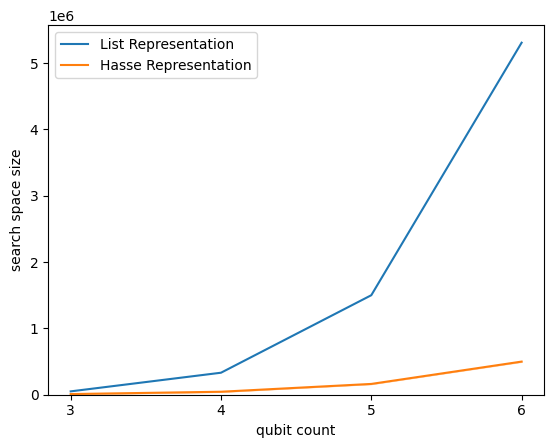

100%|██████████| 4/4 [00:00<00:00, 1175.45it/s]


Search space sizes for 5 gates.
Qubit nums:  [3, 4, 5, 6]
List search space:  [759375, 7962624, 52521875, 254803968]
List ratio between Q and Q-1:  [10.4858, 6.5961, 4.8514]
Hasse search space:  [58364, 398717, 2004851, 7778976]
Hasse ratio between Q and Q-1:  [6.8316, 5.0283, 3.8801]
Ratio:  [0.0769, 0.0501, 0.0382, 0.0305]


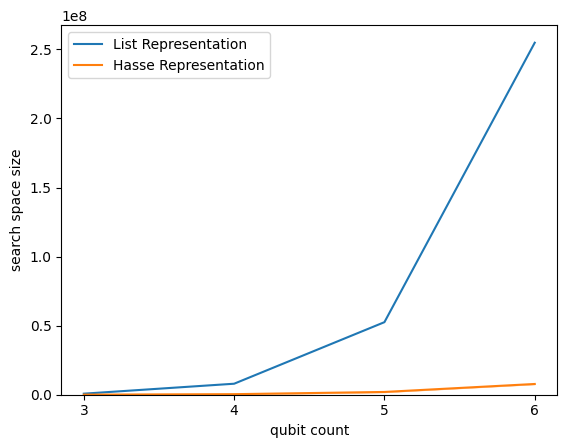

100%|██████████| 2/2 [00:00<00:00, 1066.71it/s]


Search space sizes for 6 gates.
Qubit nums:  [3, 4]
List search space:  [11390625, 191102976]
List ratio between Q and Q-1:  [16.7772]
Hasse search space:  [404899, 3560230]
Hasse ratio between Q and Q-1:  [8.7929]
Ratio:  [0.0355, 0.0186]


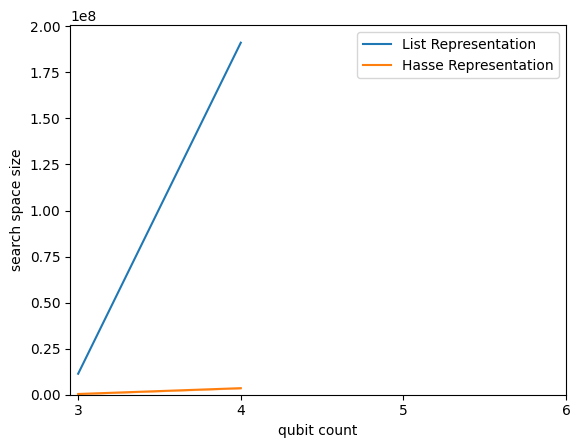

100%|██████████| 3/3 [00:00<00:00, 890.20it/s]


Search space sizes for 7 gates.
Qubit nums:  [3, 4, 5]
List search space:  [170859375, 4586471424, 64339296875]
List ratio between Q and Q-1:  [26.8435, 14.0281]
Hasse search space:  [2098007, 26527353, 236491903]
Hasse ratio between Q and Q-1:  [12.6441, 8.915]
Ratio:  [0.0123, 0.0058, 0.0037]


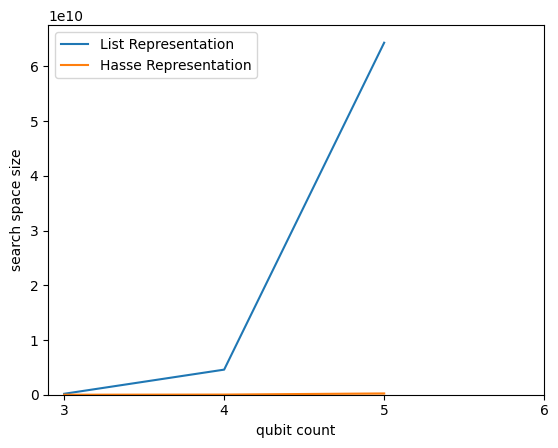

100%|██████████| 2/2 [00:00<00:00, 793.32it/s]



Search space sizes for 8 gates.
Qubit nums:  [3, 4]
List search space:  [2562890625, 110075314176]
List ratio between Q and Q-1:  [42.9497]
Hasse search space:  [12000075, 215288348]
Hasse ratio between Q and Q-1:  [17.9406]
Ratio:  [0.0047, 0.002]


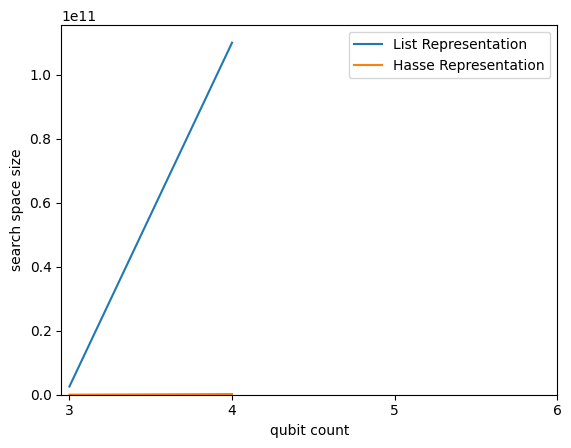

100%|██████████| 1/1 [00:00<00:00, 751.94it/s]



Search space sizes for 9 gates.
Qubit nums:  [3]
List search space:  [38443359375]
List ratio between Q and Q-1:  []
Hasse search space:  [67228251]
Hasse ratio between Q and Q-1:  []
Ratio:  [0.0017]


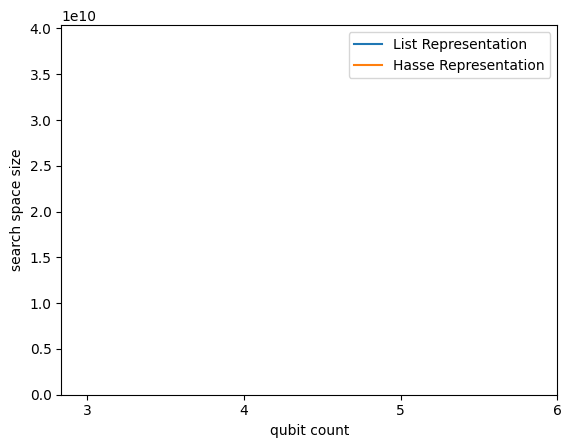

In [12]:
# accross gate counts

for gate_count in gate_counts:

    # if gate_count > 10:
    #     break

    filtered_experiments = filter_experiments(
        experiments, target_gate_counts=[gate_count])

    encountered_qubit_nums = []
    total_list_values = []
    total_hasse_estimates = []
    total_hasse_estimate_stdevs = []

    for experiment in tqdm(filtered_experiments):
        encountered_qubit_nums.append(experiment["config"]["qubit_num"])

        actual_list_size = calculate_list_search_space_size(
            experiment["config"]["qubit_num"], experiment["config"]["gate_count"])
        total_list_values.append(actual_list_size)

        hasse_mean_estimate = estimate_search_space_size(
            experiment["config"]["sample_num"], experiment["results"]["mean_hasse_duplicate_count"], lower_bound=1, upper_bound=3 * actual_list_size)
        total_hasse_estimates.append(hasse_mean_estimate)

        hasse_estimates = [
            estimate_search_space_size(
                experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=3 * actual_list_size)
            for duplicate_count in experiment["results"]["hasse_duplicate_counts"]
        ]
        total_hasse_estimate_stdevs.append(stdev(hasse_estimates))

    printb(f"\nSearch space sizes for {gate_count} gates.")
    print("Qubit nums: ", encountered_qubit_nums)
    print("List search space: ", total_list_values)
    print("List ratio between Q and Q-1: ", [
        round(list2 / list1, 4) for list2, list1 in zip(total_list_values[1:], total_list_values[:-1])
    ])
    print("Hasse search space: ", total_hasse_estimates)
    print("Hasse ratio between Q and Q-1: ", [
        round(hasse2 / hasse1, 4) for hasse2, hasse1 in zip(total_hasse_estimates[1:], total_hasse_estimates[:-1])
    ])
    print("Ratio: ", [
        round(hasse_size / list_size, 4) for list_size, hasse_size in zip(total_list_values, total_hasse_estimates)
    ])

    ax = plt.subplot()

    ax.plot(encountered_qubit_nums, total_list_values,
            label="List Representation")

    ax.plot(encountered_qubit_nums, total_hasse_estimates,
            label="Hasse Representation")

    lower_bound_of_estimates = [
        estimate - estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    upper_bound_of_estimates = [
        estimate + estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    ax.fill_between(
        encountered_qubit_nums, lower_bound_of_estimates, upper_bound_of_estimates, alpha=0.3, color="tab:orange"
    )

    ax.set_xlabel("qubit count")
    ax.set_ylabel("search space size")
    ax.set_ylim(0)

    plt.xticks(qubit_nums)

    plt.legend()
    plt.savefig(f"results/fig_space_{gate_count}g_varying_q.png", bbox_inches='tight')
    plt.show()


Search space sizes for 3 qubits.
Gate counts:  [4, 5, 6, 7, 8, 9]
List search space:  [50625, 759375, 11390625, 170859375, 2562890625, 38443359375]
List ratio between L and L-1:  [15.0, 15.0, 15.0, 15.0, 15.0]
Hasse search space:  [10059, 58362, 404903, 2097986, 12000075, 67228324]
Hasse ratio between L and L-1:  [5.802, 6.9378, 5.1815, 5.7198, 5.6023]
Ratio:  [0.1987, 0.0769, 0.0355, 0.0123, 0.0047, 0.0017]


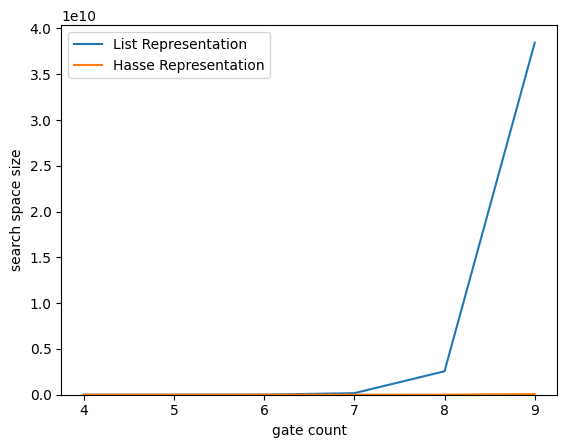


Search space sizes for 4 qubits.
Gate counts:  [4, 5, 6, 7, 8]
List search space:  [331776, 7962624, 191102976, 4586471424, 110075314176]
List ratio between L and L-1:  [24.0, 24.0, 24.0, 24.0]
Hasse search space:  [44980, 398732, 3560253, 26527216, 215288553]
Hasse ratio between L and L-1:  [8.8647, 8.9289, 7.4509, 8.1158]
Ratio:  [0.1356, 0.0501, 0.0186, 0.0058, 0.002]


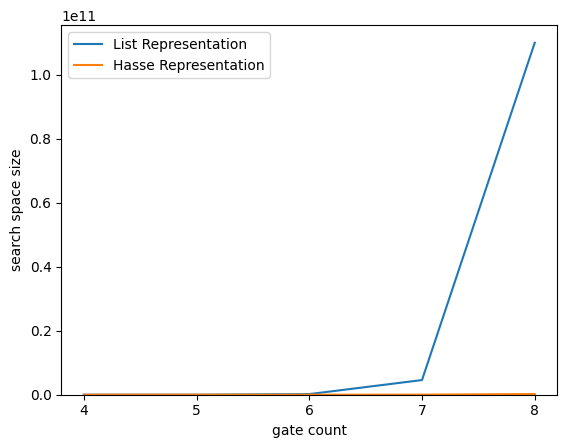


Search space sizes for 5 qubits.
Gate counts:  [4, 5, 7]
List search space:  [1500625, 52521875, 64339296875]
List ratio between L and L-1:  [35.0, 1225.0]
Hasse search space:  [162779, 2004852, 236491902]
Hasse ratio between L and L-1:  [12.3164, 117.9598]
Ratio:  [0.1085, 0.0382, 0.0037]


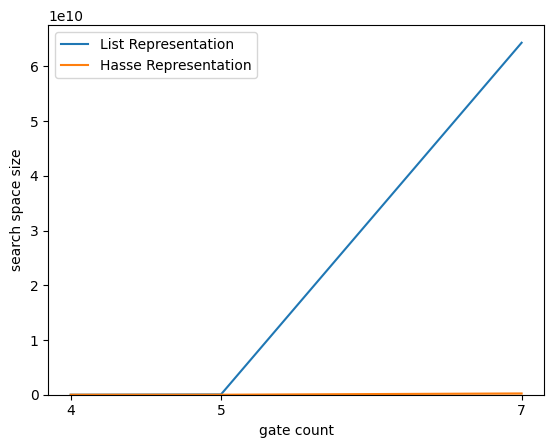


Search space sizes for 6 qubits.
Gate counts:  [4, 5]
List search space:  [5308416, 254803968]
List ratio between L and L-1:  [48.0]
Hasse search space:  [499608, 7778916]
Hasse ratio between L and L-1:  [15.57]
Ratio:  [0.0941, 0.0305]


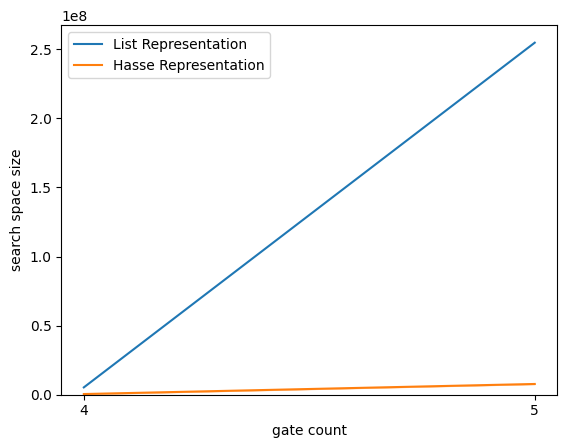

In [13]:
# accross qubit nums

for qubit_num in qubit_nums:

    # filtered_experiments = filter_experiments(experiments, target_qubit_nums=[
    #                                           qubit_num], target_gate_counts=[5, 10], sort_by="gate_count")
    filtered_experiments = filter_experiments(experiments, target_qubit_nums=[
                                              qubit_num], sort_by="gate_count")

    encountered_gate_counts = []
    total_list_values = []
    total_hasse_estimates = []
    total_hasse_estimate_stdevs = []

    for experiment in filtered_experiments:
        encountered_gate_counts.append(experiment["config"]["gate_count"])

        actual_list_size = calculate_list_search_space_size(
            experiment["config"]["qubit_num"], experiment["config"]["gate_count"])
        total_list_values.append(actual_list_size)

        hasse_mean_estimate = estimate_search_space_size(
            experiment["config"]["sample_num"], experiment["results"]["mean_hasse_duplicate_count"], lower_bound=1, upper_bound=2 * actual_list_size)
        total_hasse_estimates.append(hasse_mean_estimate)

        hasse_estimates = [
            estimate_search_space_size(
                experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=2 * actual_list_size)
            for duplicate_count in experiment["results"]["hasse_duplicate_counts"]
        ]
        total_hasse_estimate_stdevs.append(stdev(hasse_estimates))

    printb(f"\nSearch space sizes for {qubit_num} qubits.")
    print("Gate counts: ", encountered_gate_counts)
    print("List search space: ", total_list_values)
    print("List ratio between L and L-1: ", [
        round(list2 / list1, 4) for list2, list1 in zip(total_list_values[1:], total_list_values[:-1])
    ])
    print("Hasse search space: ", total_hasse_estimates)
    print("Hasse ratio between L and L-1: ", [
        round(hasse2 / hasse1, 4) for hasse2, hasse1 in zip(total_hasse_estimates[1:], total_hasse_estimates[:-1])
    ])
    print("Ratio: ", [
        round(hasse_size / list_size, 4) for list_size, hasse_size in zip(total_list_values, total_hasse_estimates)
    ])

    ax = plt.subplot()

    ax.plot(encountered_gate_counts, total_list_values,
            label="List Representation")

    ax.plot(encountered_gate_counts, total_hasse_estimates,
            label="Hasse Representation")

    lower_bound_of_estimates = [
        estimate - estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    upper_bound_of_estimates = [
        estimate + estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    ax.fill_between(
        encountered_gate_counts, lower_bound_of_estimates, upper_bound_of_estimates, alpha=0.3, color="tab:orange"
    )

    ax.set_xlabel("gate count")
    ax.set_ylabel("search space size")
    ax.set_ylim(0)

    plt.xticks(encountered_gate_counts)

    plt.legend()

    plt.savefig(
        f"results/fig_space_{qubit_num}q_varying_g.png", bbox_inches='tight')
    plt.show()